<h1><center>Прогнозирование оттока клиентов телеком компании.

## Описание данных:
1. contract_data содержит столбцы с информацией о договоре: ID клиента, даты начала и окончания договора, тип оплаты, возможность получения электронного чека, способы расчёта, ежемесячные платежи и суммарные расходы;
2. personal_data содержит столбцы с информацией о персональных данных клиентов: ID клиента, пол, является ли клиент пожилым, есть ли у него партнер и иждивенцы;
3. internet_data содержит столбцы с информацией об интернет-услугах: ID клиента, тип подключения, наличие блокировки небезопасных сайтов, облачного хранилища, антивируса, выделенной линии технической поддержки, стримингового телевидения и каталога фильмов;
4. phone_data содержит столбцы с информацией об услугах телефонии: ID клиента и возможность подключения телефонного аппарата к нескольким линиям одновременно.

## План работы:

1. Предобработка и анализ данных:
 - приведение данных к верному формату; 
 - удаление лишних переменных и создание новых;
 - построение графиков, выявление взаимосвязей.
2. Подготовка данных к обучению:
 - выявление дисбаланса классов, возможной мультиколлениарности;
 - возможно изменение состава признаков, используемых для предсказаний;
 - перевод категориальных признаков в численные;
 - деление на выборки.
3. Обучение различных моделей и подбор гиперпараметров, анализ важности факторов.
4. Тестирование модели с лучшим показателем метрики AUC-ROC.

# 1. Подготовка данных.

Загрузим все необходимые библиотеки:

In [1]:
import pandas as pd

import numpy as np
from numpy import median

from datetime import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

import lightgbm as lgbm
from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

Прочитаем файл datasets/final_provider/contract.csv и сохраним его в переменной contract_data. Получим первые 15 строк таблицы:

In [2]:
contract_data = pd.read_csv('/datasets/final_provider/contract.csv')
contract_data.head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [5]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Отсортируем данные по самым поздним заключенным договорам:

In [6]:
contract_data.sort_values('BeginDate', ascending=False).head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6754,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,


Отсортируем данные по самым ранним заключенным договорам:

In [7]:
contract_data.sort_values('BeginDate', ascending=True).head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4513,8580-QVLOC,2013-10-01,2019-10-01 00:00:00,Two year,No,Credit card (automatic),92.45,6440.25
4610,2889-FPWRM,2013-10-01,2019-10-01 00:00:00,One year,Yes,Bank transfer (automatic),117.80,8684.8
3439,0917-EZOLA,2013-10-01,2019-10-01 00:00:00,Two year,Yes,Bank transfer (automatic),104.15,7689.95
975,2834-JRTUA,2013-11-01,2019-10-01 00:00:00,Two year,Yes,Electronic check,108.05,7532.15
3040,7317-GGVPB,2013-11-01,2019-10-01 00:00:00,Two year,Yes,Credit card (automatic),108.60,7690.9
6038,1555-DJEQW,2013-12-01,2019-10-01 00:00:00,Two year,Yes,Bank transfer (automatic),114.20,7723.9
6290,2530-ENDWQ,2013-12-01,2019-11-01 00:00:00,Two year,Yes,Bank transfer (automatic),93.70,6585.35
5441,3512-IZIKN,2013-12-01,2019-10-01 00:00:00,Two year,No,Credit card (automatic),65.30,4759.75
6424,6034-ZRYCV,2014-01-01,2020-01-01 00:00:00,Two year,Yes,Electronic check,54.20,3937.45
4684,6305-YLBMM,2014-01-01,2019-10-01 00:00:00,One year,Yes,Bank transfer (automatic),104.05,7262


Преобразуем дату в верный формат:

In [8]:
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'], format='%Y-%m-%d')

Так как данные предоставлены на начало февраля 2020 года, а также присутствует незначительная часть данных за 2013 год, возьмем за актуальный период примерно 5 лет, т.е. договоры с датой заключения с января 2014 по январь 2019 включительно, так как по более свежим договорам может быть ещё не сформирована история, а по слишком старым - наоборот, неактуальна.

In [9]:
contract_data = contract_data.query('"2013-12-01" < BeginDate <= "2019-01-01"').reset_index(drop = True)

Добавим данные по "времени жизни клиента". Для этого сначала продублируем колонку "EndDate", но по нерасторженным договорам вместо "No" подставим актуальную дату, т.е. февраль 2020 года.

In [10]:
contract_data['EndDate_1'] = contract_data['EndDate']
contract_data['EndDate_1']  = contract_data['EndDate'].replace("No", "2020-02-01")

In [11]:
contract_data['EndDate_1'] = pd.to_datetime(contract_data['EndDate_1'], format='%Y-%m-%d')

In [12]:
contract_data.head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_1
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2020-02-01
1,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2020-02-01
2,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,2020-02-01
3,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,2019-11-01
4,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,2020-02-01
5,9763-GRSKD,2019-01-01,No,Month-to-month,Yes,Mailed check,49.95,587.45,2020-02-01
6,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.8,2020-02-01
7,8091-TTVAX,2015-04-01,No,One year,No,Credit card (automatic),100.35,5681.1,2020-02-01
8,0280-XJGEX,2015-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,2019-10-01
9,5129-JLPIS,2018-01-01,No,Month-to-month,Yes,Electronic check,105.50,2686.05,2020-02-01


Посчитаем продолжительность в днях и сохраним в столбце "LTV"

In [13]:
contract_data['LTV'] = (contract_data['EndDate_1'] - contract_data['BeginDate']).dt.days
contract_data.head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_1,LTV
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2020-02-01,1036
1,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2020-02-01,1371
2,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,2020-02-01,671
3,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,2019-11-01,853
4,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,2020-02-01,1888
5,9763-GRSKD,2019-01-01,No,Month-to-month,Yes,Mailed check,49.95,587.45,2020-02-01,396
6,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.8,2020-02-01,488
7,8091-TTVAX,2015-04-01,No,One year,No,Credit card (automatic),100.35,5681.1,2020-02-01,1767
8,0280-XJGEX,2015-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,2019-10-01,1491
9,5129-JLPIS,2018-01-01,No,Month-to-month,Yes,Electronic check,105.50,2686.05,2020-02-01,761


Столбцы с датами нам больше не понадобятся, удалим их:

In [14]:
del contract_data['EndDate_1']
del contract_data['BeginDate']

Переведем данные по итоговому чеку в верный формат:

In [15]:
contract_data['TotalCharges'] = contract_data['TotalCharges'].astype(float)

Получим общую информацию по обработанной таблице:

In [16]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 8 columns):
customerID          4948 non-null object
EndDate             4948 non-null object
Type                4948 non-null object
PaperlessBilling    4948 non-null object
PaymentMethod       4948 non-null object
MonthlyCharges      4948 non-null float64
TotalCharges        4948 non-null float64
LTV                 4948 non-null int64
dtypes: float64(2), int64(1), object(5)
memory usage: 309.4+ KB


Построим гистограмму и ящик с усами, чтобы оценить распределение и наличие выбросов по времени жизни клиента:

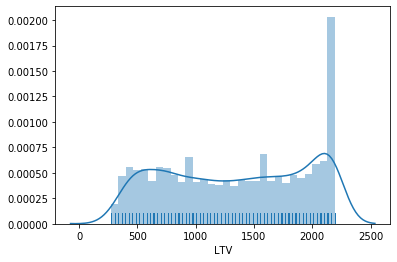

In [17]:
sns.distplot(contract_data['LTV'], bins = 30, rug=True)

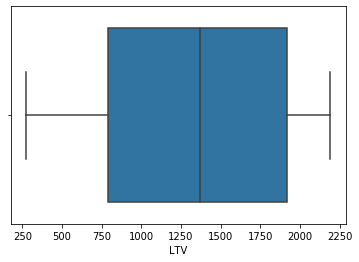

In [18]:
sns.boxplot(contract_data['LTV'])

In [19]:
contract_data.describe()

,MonthlyCharges,TotalCharges,LTV
count,4948.000000,4948.000000,4948.000000
mean,68.792068,3128.706427,1342.639450
std,30.658189,2188.118923,597.128308
min,18.250000,180.300000,273.000000
25%,44.450000,1266.287500,792.000000
50%,75.550000,2531.600000,1371.000000
75%,94.662500,4811.887500,1918.000000
max,118.750000,8672.450000,2191.000000


### Вывод:

Из графиков следует, что аномальных значений в данных нет, а средняя продолжительность пользования услугами составляет примерно 3 года 9 месяцев.

Для нас имеет значение только ушёл клиент или нет, это и будет целевым признаком. Заменим в столбце "EndDate" No на 0, а указанную дату на 1, что будет означать, что договор был расторгнут.

In [20]:
contract_data.loc[(contract_data['EndDate'] != "No"), 'EndDate'] = 1
contract_data.loc[(contract_data['EndDate'] == "No"), 'EndDate'] = 0

In [21]:
contract_data.head(3)

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LTV
0,5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036
1,7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371
2,1452-KIOVK,0,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,671


Прочитаем файл datasets/final_provider/personal.csv и сохраним его в переменной personal_data. Получим первые 15 строк таблицы:

In [22]:
personal_data = pd.read_csv('/datasets/final_provider/personal.csv')
personal_data.head(15)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


Получим общую информацию:

In [23]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Объединим данную таблицу с предыдущей по ID пользователя и сохраним в переменной final_data:

In [24]:
final_data = contract_data.merge(personal_data, on = 'customerID')
final_data.head()

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LTV,gender,SeniorCitizen,Partner,Dependents
0,5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036,Male,0,No,No
1,7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371,Male,0,No,No
2,1452-KIOVK,0,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,671,Male,0,No,Yes
3,7892-POOKP,1,Month-to-month,Yes,Electronic check,104.80,3046.05,853,Female,0,Yes,No
4,6388-TABGU,0,One year,No,Bank transfer (automatic),56.15,3487.95,1888,Male,0,No,Yes


С помощью графиков рассмотрим как влияют персональные данные на продолжительность использования услуг.

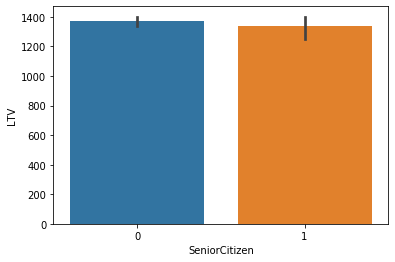

In [25]:
sns.barplot(x='SeniorCitizen', y='LTV', data=final_data, estimator=median)

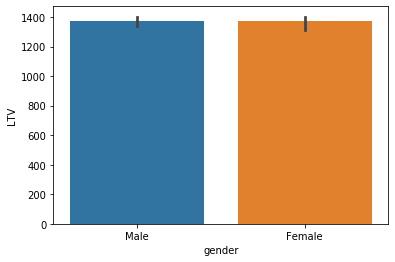

In [26]:
sns.barplot(x='gender', y='LTV', data=final_data, estimator=median)

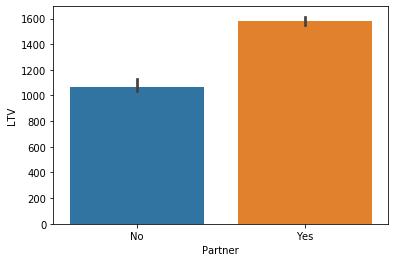

In [27]:
sns.barplot(x='Partner', y='LTV', data=final_data, estimator=median)

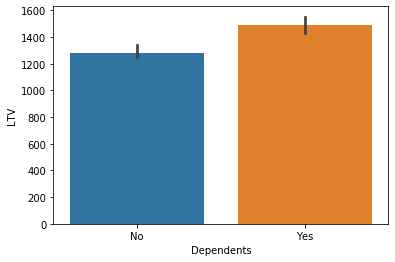

In [28]:
sns.barplot(x='Dependents', y='LTV', data=final_data, estimator=median)

Из графиков видно, что наибольшее влияние оказывает семейное положение, в то время как пол не имеет значения. Поэтому удалим данный столбец:

In [29]:
del final_data['gender']

В случае с возрастом клиента, сформируем нулевую гипотезу Н0 о том, что средняя продолжительность пользования услугами пожилых людей и нет равны и альтернативную гипотезу Н1 о том, что средняя продолжительность пользования услугами пожилых людей и нет отличаются. Уровень статистической значимости установим равный 0.05.

Сначала проверим с помощью критерия Флигнера-Килина, равны ли дисперсии:

In [30]:
stat_data_sz = final_data.query('SeniorCitizen == 1')
stat_data_no = final_data.query('SeniorCitizen == 0')

In [31]:
result = st.fligner(stat_data_sz['LTV'], stat_data_no['LTV'])
print('p-value: ', result[1])

p-value:  0.6202853795436527


Значение p-value больше альфа, гипотезу о равенстве дисперсий не отвергаем. Поэтому гипотезу о равенстве средних значений будем проверять с помощью ttest_ind с опцией equal_var=True:

In [32]:
result = st.ttest_ind(stat_data_sz['LTV'], stat_data_no['LTV'], equal_var=True)
print('p-value: ', result[1])

p-value:  0.22497578896846054


Значение p-value больше критического уровня статистической значимости, соответственно нулевую гипотезу о том, что средняя продолжительность пользования услугами пожилых людей и нет равны не отвергаем. Поэтому также удалим данный столбец:

In [33]:
del final_data['SeniorCitizen']

Прочитаем файл datasets/final_provider/internet.csv и сохраним его в переменной internet_data. Получим первые 15 строк таблицы:

In [34]:
internet_data = pd.read_csv('/datasets/final_provider/internet.csv')
internet_data.head(15)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


Получим общую информацию по таблице:

In [35]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


Присоединим таблицу к предыдущей:

In [36]:
final_data = final_data.merge(internet_data, on = 'customerID', how='left')
final_data.head()

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LTV,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036,No,No,DSL,Yes,No,Yes,No,No,No
1,7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371,No,No,DSL,Yes,No,Yes,Yes,No,No
2,1452-KIOVK,0,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,671,No,Yes,Fiber optic,No,Yes,No,No,Yes,No
3,7892-POOKP,1,Month-to-month,Yes,Electronic check,104.80,3046.05,853,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes
4,6388-TABGU,0,One year,No,Bank transfer (automatic),56.15,3487.95,1888,No,Yes,DSL,Yes,Yes,No,No,No,No


Прочитаем файл datasets/final_provider/phone.csv и сохраним его в переменной phone_data. Получим первые 15 строк таблицы:

In [37]:
phone_data = pd.read_csv('/datasets/final_provider/phone.csv')
phone_data.head(15)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Получим общую информацию:

In [38]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Также присоединим к предыдущей и получим финальную таблицу: 

In [39]:
final_data = final_data.merge(phone_data, on = 'customerID', how='left')
final_data.head()

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LTV,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036,No,No,DSL,Yes,No,Yes,No,No,No,No
1,7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
2,1452-KIOVK,0,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,671,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
3,7892-POOKP,1,Month-to-month,Yes,Electronic check,104.80,3046.05,853,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
4,6388-TABGU,0,One year,No,Bank transfer (automatic),56.15,3487.95,1888,No,Yes,DSL,Yes,Yes,No,No,No,No,No


Получим общую информацию по финальной таблице:

In [40]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4948 entries, 0 to 4947
Data columns (total 18 columns):
customerID          4948 non-null object
EndDate             4948 non-null int64
Type                4948 non-null object
PaperlessBilling    4948 non-null object
PaymentMethod       4948 non-null object
MonthlyCharges      4948 non-null float64
TotalCharges        4948 non-null float64
LTV                 4948 non-null int64
Partner             4948 non-null object
Dependents          4948 non-null object
InternetService     3930 non-null object
OnlineSecurity      3930 non-null object
OnlineBackup        3930 non-null object
DeviceProtection    3930 non-null object
TechSupport         3930 non-null object
StreamingTV         3930 non-null object
StreamingMovies     3930 non-null object
MultipleLines       4479 non-null object
dtypes: float64(2), int64(2), object(14)
memory usage: 734.5+ KB


Из данных видно, что в таблицах "phone_data" и "internet_data" данных меньше. В результате чего в итоговой таблице образовались пропущенные значения, которые означают, что абонент пользуется моноуслугой - либо только телефонией, либо только интернетом. Заменим такие значения на 0, т.е. данная услуга у абонента отсутствует.

In [41]:
final_data = final_data.fillna(0)

Удалим столбец с ID абонентов:

In [42]:
del final_data['customerID']

Построим матрицу корреляции численных признаков:

In [43]:
df = final_data
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,EndDate,MonthlyCharges,TotalCharges,LTV
EndDate,1,0.23,-0.071,-0.28
MonthlyCharges,0.23,1,0.74,0.16
TotalCharges,-0.071,0.74,1,0.72
LTV,-0.28,0.16,0.72,1


Наличие больших по модулю (выше 0,7-0,8) значений коэффициентов парной корреляции свидетельствует о возможной мультиколлениарности. В данном случае, это столбцы:
 - MonthlyCharges и TotalCharges (0.74)
 - LTV и TotalCharges (0.72)

В обоих случаях присутствует колонка "TotalCharges", также с ним наименьшая корреляция целевого признака, поэтому удалим этот столбец:

In [44]:
del final_data['TotalCharges']

Получим информацию по итоговой таблице:

In [45]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4948 entries, 0 to 4947
Data columns (total 16 columns):
EndDate             4948 non-null int64
Type                4948 non-null object
PaperlessBilling    4948 non-null object
PaymentMethod       4948 non-null object
MonthlyCharges      4948 non-null float64
LTV                 4948 non-null int64
Partner             4948 non-null object
Dependents          4948 non-null object
InternetService     4948 non-null object
OnlineSecurity      4948 non-null object
OnlineBackup        4948 non-null object
DeviceProtection    4948 non-null object
TechSupport         4948 non-null object
StreamingTV         4948 non-null object
StreamingMovies     4948 non-null object
MultipleLines       4948 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 657.2+ KB


Проверим данные на дисбаланс классов:

In [46]:
final_data['EndDate'].value_counts(normalize=True)

0    0.81346
1    0.18654
Name: EndDate, dtype: float64

Абонентов, которые расторгли договор гораздо меньше - 18,65%, для борьбы с дисбалансом будем исполльзовать параметр "class_weight='balanced'".

Переведем категориальные признаки в численные техникой OHE:

In [47]:
pd.set_option('display.max_columns', 50)
final_data = pd.get_dummies(final_data, drop_first=True)
final_data.head()

,EndDate,MonthlyCharges,LTV,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes
0,0,56.95,1036,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0
1,0,42.30,1371,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0,0,0
2,0,89.10,671,0,0,1,1,0,0,0,1,0,1,1,0,0,1,1,0,1,0,0,1,1,0,0,1
3,1,104.80,853,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1
4,0,56.15,1888,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0


Разделим данные на обучающую и тестовую выборки в процентном соотношении 80 к 20 соответственно:

In [48]:
df_train, df_test = train_test_split(final_data, test_size=0.20, random_state=12345)

Признаки сохраним в переменных features для каждой выборки. Для целевого признака создадим переменные target:

In [49]:
features_train = df_train.drop(['EndDate'], axis=1)
target_train = df_train['EndDate']
features_test = df_test.drop(['EndDate'], axis=1)
target_test = df_test['EndDate']

Выведем на экран размеры переменных:

In [50]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3958, 26)
(3958,)
(990, 26)
(990,)


Стандартизируем численные признаки с помощью StandardScaler:

In [51]:
pd.set_option('display.max_columns', 50)
scaler = StandardScaler()
scaler.fit(features_train[['MonthlyCharges','LTV']])
features_train[['MonthlyCharges','LTV']] = scaler.transform(features_train[['MonthlyCharges','LTV']])
features_test[['MonthlyCharges','LTV']] = scaler.transform(features_test[['MonthlyCharges','LTV']])
features_train.head()

,MonthlyCharges,LTV,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,Dependents_Yes,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes
3780,-1.588050,-0.686102,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1342,-1.078666,-0.227084,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,0
604,0.842576,-1.146801,0,0,1,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1
1215,0.672236,1.002009,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1
842,1.165240,-0.381771,1,0,1,1,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1


# 2. Обучение моделей

Напишем функцию для итогового анализа моделей: расчета времени обучения, предсказания и качества модели:

In [52]:
def models_results(model, X_train, Y_train, X_test, Y_test):
    
    predict_test = model.predict(X_test)
    
    probabilities_test = model.predict_proba(X_test)
    probabilities_one_test = probabilities_test[:, 1]
    roc_auc = roc_auc_score(Y_test, probabilities_one_test)
    
    return model.best_score_, roc_auc, accuracy_score(Y_test, predict_test)

Создадим контейнер, для сбора итоговых данных по каждой модели:

In [53]:
results = []

## 2.1 LGBMClassifier

Обучим модель с наилучшими параметрами посредством кросс-валидации:

In [54]:
model_1 = LGBMClassifier(random_state=12345, n_estimators = 120, class_weight='balanced')

In [55]:
tree_params = {'max_depth': [-1, 3, 6],
               'learning_rate': [0.1, 0.3, 0.5],
               'num_leaves': [21, 31, 41]}

In [56]:
LGBM_grid = GridSearchCV(model_1, tree_params, cv=5, scoring='roc_auc', verbose=False)

In [57]:
%%time
LGBM_grid.fit(features_train, target_train)

CPU times: user 3min 42s, sys: 2.41 s, total: 3min 44s
Wall time: 3min 47s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=120,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=12345, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate

Выведем на экран наилучшее сочетание параметров:

In [58]:
LGBM_grid.best_params_

{'learning_rate': 0.5, 'max_depth': 3, 'num_leaves': 21}

Выведем на экран значение AUC_ROC на валидационной выборке:

In [59]:
LGBM_grid.best_score_

0.8923655469507323

Посмотрим на важность факторов для модели:

In [60]:
importances = pd.DataFrame({'Features':features_train.columns,
                            'Importance':LGBM_grid.best_estimator_.feature_importances_})
importances = importances.sort_values('Importance', ascending=False)
importances

,Features,Importance
1,LTV,364
0,MonthlyCharges,214
4,PaperlessBilling_Yes,21
9,Dependents_Yes,18
2,Type_One year,16
7,PaymentMethod_Mailed check,16
12,OnlineSecurity_No,15
5,PaymentMethod_Credit card (automatic),14
6,PaymentMethod_Electronic check,13
24,MultipleLines_No,12


Построим график важности факторов:

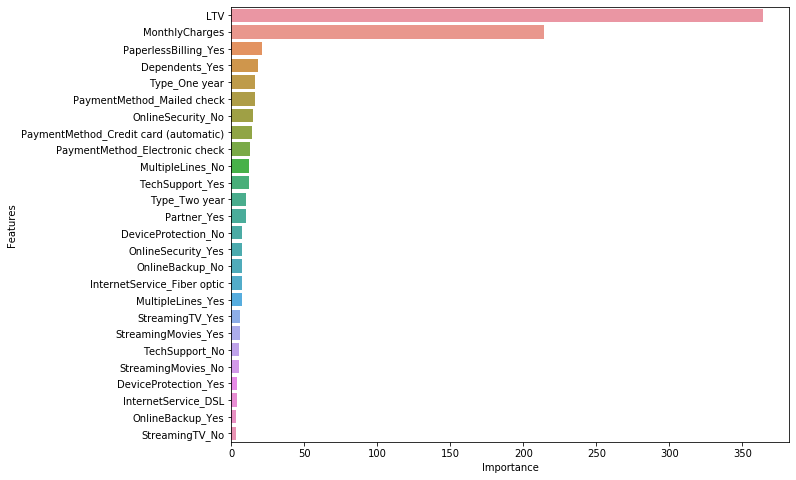

In [61]:
plt.figure(figsize=(10,8))
sns.barplot(x='Importance',y='Features',data=importances)

### Вывод:

Из графика видно, что наибольшее вляние оказывает продолжительность пользования услугами и ежемесячная плата. Наименьшее значение имеет, в основном, наличие дополнительных услуг. Уберем из выборки переменные с важностью меньше 10.

In [62]:
features_train.columns

Index(['MonthlyCharges', 'LTV', 'Type_One year', 'Type_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Partner_Yes', 'Dependents_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'OnlineSecurity_No',
       'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_Yes', 'MultipleLines_No',
       'MultipleLines_Yes'],
      dtype='object')

In [63]:
features_train_2 = features_train.drop(['InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
                                      'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No',
                                      'DeviceProtection_Yes', 'TechSupport_No', 'StreamingTV_No',
                                      'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
                                      'MultipleLines_Yes'], axis = 1)

In [64]:
features_test_2 = features_test.drop(['InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
                                    'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No',
                                    'DeviceProtection_Yes', 'TechSupport_No', 'StreamingTV_No',
                                    'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
                                    'MultipleLines_Yes'], axis = 1)

Обучим модель по измененным данным:

In [65]:
LGBMC_grid = GridSearchCV(model_1, tree_params, cv=5, scoring='roc_auc', verbose=False)

In [66]:
%%time
LGBMC_grid.fit(features_train_2, target_train)

CPU times: user 2min 43s, sys: 1.89 s, total: 2min 45s
Wall time: 2min 48s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=120,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=12345, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate

Выведем на экран наилучшее сочетание параметров:

In [67]:
LGBMC_grid.best_params_

{'learning_rate': 0.5, 'max_depth': 3, 'num_leaves': 21}

Выведем на экран значение AUC_ROC на валидационной выборке:

In [68]:
LGBMC_grid.best_score_

0.8966706692004879

Добавим итоги выполнения функции models_results в контейнер для финального анализа:

In [69]:
results.append(models_results(LGBMC_grid, features_train_2, target_train, features_test_2, target_test))

## 2.2 XGBClassifier

Обучим модель с наилучшими параметрами посредством кросс-валидации:

In [70]:
model_2 = XGBClassifier(random_state=12345, n_estimators = 150, class_weight='balanced')

In [71]:
tree_params = {'max_depth': [2, 3, 4],
               'learning_rate': [0.1, 0.3, 0.5],
               'min_child_weight': range(1,10,2)}

In [72]:
XGBC_grid = GridSearchCV(model_2, tree_params, cv=5, scoring='roc_auc', verbose=False)

In [73]:
%%time
XGBC_grid.fit(features_train_2, target_train)

CPU times: user 1min 17s, sys: 399 ms, total: 1min 18s
Wall time: 1min 19s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     class_weight='balanced',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=150, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=12345, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
     

Выведем на экран наилучшее сочетание параметров:

In [74]:
XGBC_grid.best_params_

{'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 1}

Выведем на экран значение AUC_ROC на валидационной выборке:

In [75]:
XGBC_grid.best_score_

0.9069641188829458

Добавим итоги выполнения функции models_results в контейнер для финального анализа:

In [76]:
results.append(models_results(XGBC_grid, features_train_2, target_train, features_test_2, target_test))

# 3. Анализ моделей

Для наглядности выведем итоги на экран в виде таблицы:

In [77]:
pd.DataFrame(data=results,
              index=['LightGBM', 'XGBoost'],
              columns=['Roc_Auc_valid', 'Roc_Auc_test', 'Accuracy'])

,Roc_Auc_valid,Roc_Auc_test,Accuracy
LightGBM,0.896671,0.884698,0.826263
XGBoost,0.906964,0.896066,0.891919


# Вывод:

План по работе полностью выполнен, а именно были проведены следующие этапы:

1. Предобработка данных: 
 - приведение данных к верному формату;
 - заполнение пропущенных значений;
 - объединение всех данных в одну таблицу.

2. Исследовательский анализ данных:
 - был выделен актуальный период с датой заключения договора с 2014 года по январь 2019 года включительно, так как данные по договорам 7-летней давности (2013 года) могут быть уже не актуальны, а позднее января 2019 года – не информативны, так как история абонента может быть еще полностью не сформирована;
 - выделен целевой признак – ушёл клиент или нет,
 - добавлена и рассчитана новая переменная LTV – «продолжительность жизни абонента», выявлено среднее значение – 3 года 9 месяцев.
 - оценено влияние семейного положения, пола и является ли абонент пожилым на продолжительность пользования услугами, проверена статистическая гипотеза. В результате было выявлено, что на продолжительность жизни абонента значимо влияет только семейное положение, т.е. есть ли дети и есть ли партнер.
 - выявлена проблема дисбаланса класса (т.е. ушедших абонентов гораздо меньше в данных – 18.65%, чем тех, кто продолжает пользоваться услугами - 81.35%) которая была решена дополнительным параметром модели «class_weight='balanced'»;
 - построена матрица корреляции, в результате чего была выявлена проблема мультиколлениарности (высокой зависимости двух признаков друг от друга, что может повлиять на качество модели). Такая зависимость наблюдалась между ежемесячной и итоговой абонентской платой, а также продолжительностью пользования услугами и также итоговыми платежами. Дополнительно было оценено влияние этих столбцов на целевой признак и принято решение удалить столбец с итоговой суммой платежей.

3. Обучение моделей:
 - мной были рассмотрены две модели градиентного бустинга: LightGBM и XGBoost;
 - Посредством кросс-валидации подобраны наилучшие параметры;
 - построен график важности факторов для целевого признака и отброшены малозначимые, что позволило улучшить показатели модели.
 
4. Итоговый анализ моделей:
 - для удобства сравнения были собраны в единую таблицу по обоим моделям метрики качества ROC_AUC на валидационной и тестовой выборках и Accuracy на тестовой выборке. Мной была выбрана модель классификации XGBoost, так как она показала лучшие результаты ROC_AUC как на обучающей (0.907), так и на тестовой (0.896) выборках с точностью предсказаний на тестовой выборке 89,2%.